In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import brom_functions as bf
import plot_functions as pf
import linear_fit_functions as lff

#### Open an initial dataset (observed values)

In [2]:
ds = xr.open_dataset('wadden_sea_out.nc')
df = ds.to_dataframe()
levelcntr = df.groupby('levelcntr').get_group(0.625)
levelface = levelcntr.groupby('levelface').get_group(0)
levelface.describe()

,par,hice,snowthick,icesurft,temperature,salinity,sigma,turbulence,nitrate,silicate,phosphate,oxygen,donflux,gpp,chl_a
count,365.000000,365.0,365.0,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,56.332401,0.0,0.0,0.0,9.762181,30.002657,23.694701,0.000059,11.562565,8.849457,0.559331,412.414331,1.895625,5.326875,4.809650
std,23.070065,0.0,0.0,0.0,6.327322,1.061367,0.593105,0.000048,9.624196,7.332768,0.401733,79.875718,1.193110,3.352747,3.704244
min,21.644333,0.0,0.0,0.0,1.243333,28.625527,22.625049,0.000013,0.115774,0.325987,0.076893,248.039256,0.210641,0.591919,0.000000
25%,33.247036,0.0,0.0,0.0,4.027208,29.050626,23.300360,0.000035,0.599444,1.870370,0.140375,362.262903,0.706717,1.985937,2.521583
50%,58.778526,0.0,0.0,0.0,8.949562,29.681462,23.585972,0.000056,11.561208,6.149211,0.501802,392.995298,1.895625,5.326875,4.386667
75%,79.421547,0.0,0.0,0.0,15.415418,30.894287,24.192682,0.000074,18.925000,16.725000,0.858421,459.170881,3.084533,8.667813,5.698333
max,86.162720,0.0,0.0,0.0,20.298375,31.924390,25.074524,0.000583,28.034101,23.774999,1.240000,576.916275,3.580609,10.061831,18.415614


In [3]:
par = levelface['par'].values.astype(np.float64)
temperature = levelface['temperature'].values.astype(np.float64)
no3_data = levelface['nitrate'].values.astype(np.float64)
po4_data = levelface['phosphate'].values.astype(np.float64)
si_data = levelface['silicate'].values.astype(np.float64)
o2_data = levelface['oxygen'].values.astype(np.float64)
chl_a_data = levelface['chl_a'].values.astype(np.float64)
# daily irradiance
irradiance = par*86400/1000000 # convertion microM per second to M per day

#### Parameters

In [4]:
depth = 0.625; k=0; latitude=54.88; days = np.arange(0,364,1)

nh4 = np.zeros(365); nh4[0] = 0.1 
no2 = np.zeros(365); no2[0] = 0.1
no3 = np.zeros(365); no3[0] = no3_data[0] 
si = np.zeros(365); si[0] = si_data[0] 
po4 = np.zeros(365); po4[0] = po4_data[0] 
o2 = np.zeros(365); o2[0] = o2_data[0] 

phy = np.zeros(365); phy[0] = 1
# daily irradiance, convertion microM per second to M per day
irradiance = par*86400/1000000
knh4_lim=0.5; knox_lim=1; ksi_lim=1; kpo4_lim=0.1; pbm=8; alpha=0.03; kexc=0.015; kmortality=0.0002

het = np.zeros(365); het[0] = 1
k_het_phy_gro=0.4; k_het_phy_lim=2; k_het_pom_gro=0.4; k_het_pom_lim=2
k_het_res=0.015; k_het_mort=0.1; uz=0.5; hz=0.5

k_nfix = 0.4; k_nitrif1=0.1; k_nitrif2=0.1; o2s_nf=5; k_anammox=0.8; o2s_dn=10

poml = np.zeros(365); poml[0] = 1; pomr = np.zeros(365); pomr[0] = 1
doml = np.zeros(365); domr = np.zeros(365)
k_poml_doml=0.15; k_pomr_domr=0.00001; k_omox_o2=1; tref=0
k_doml_ox=0.1; k_poml_ox=0.05; k_domr_ox=0.1; k_pomr_ox=0.05

#### Run simulation

In [5]:
chl_a, phy_dgrate, rations = bf.calculate(
    depth, k, latitude, 
    days, temperature, 
    nh4, no2, no3, si, po4, o2,
    phy, par, irradiance, 
    knh4_lim, knox_lim, ksi_lim, kpo4_lim, pbm, alpha, kexc, kmortality,
    het, k_het_phy_gro, k_het_phy_lim, k_het_pom_gro, k_het_pom_lim, k_het_res, k_het_mort, uz, hz,
    k_nfix, k_nitrif1, k_nitrif2, o2s_nf, k_anammox, o2s_dn,
    poml, doml, pomr, domr, 
    k_poml_doml, k_pomr_domr, k_omox_o2, tref, k_doml_ox, k_poml_ox, k_domr_ox, k_pomr_ox)

In [6]:
rations['phy']['c_to_p'];

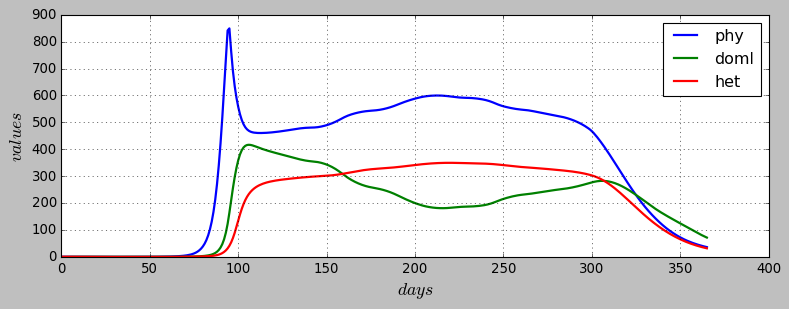

In [7]:
pf.plot_triple(phy,'phy',doml,'doml',het,'het')

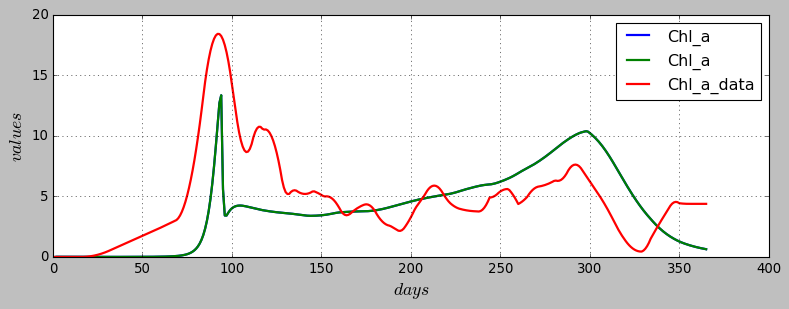

In [8]:
pf.plot_triple(chl_a,'Chl_a',chl_a,'Chl_a',chl_a_data,'Chl_a_data')

In [9]:
foo = lff.run_least_squares(lff.construct_least_squares(depth, k, latitude,
        days, temperature,
        nh4, no2, no3, si, po4, o2,
        phy, par, irradiance, 
        het, uz, hz,
        k_nfix, k_nitrif1, k_nitrif2, o2s_nf, k_anammox, o2s_dn,
        poml, doml, pomr, domr, 
        k_poml_doml, k_pomr_domr, k_omox_o2, tref, k_doml_ox, k_poml_ox, k_domr_ox, k_pomr_ox,
        chl_a_data))

In [10]:
lff.report_values(foo)

[[Variables]]
    knh4_lim:       0.5 (fixed)
    knox_lim:       1 (fixed)
    ksi_lim:        1 (fixed)
    kpo4_lim:       0.1 (fixed)
    pbm:            8 (fixed)
    alpha:          0.03516262 +/- 0.00121052 (3.44%) (init = 0.03)
    kexc:           0.015 (fixed)
    kmort:          5.9191e-04 +/- 8.1066e-05 (13.70%) (init = 0.0005)
    k_het_phy_gro:  0.4 (fixed)
    k_het_phy_lim:  2 (fixed)
    k_het_pom_gro:  0.4 (fixed)
    k_het_pom_lim:  2 (fixed)
    k_het_res:      0.015 (fixed)
    k_het_mort:     0.1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, kmort) =  0.851


In [11]:
knh4_lim = lff.return_par_values(foo, 'knh4_lim')
knox_lim = lff.return_par_values(foo, 'knox_lim')
ksi_lim  = lff.return_par_values(foo, 'ksi_lim')
kpo4_lim = lff.return_par_values(foo, 'kpo4_lim')
pbm      = lff.return_par_values(foo, 'pbm')
alpha    = lff.return_par_values(foo, 'alpha')
kexc     = lff.return_par_values(foo, 'kexc')
kmort    = lff.return_par_values(foo, 'kmort')
k_het_phy_gro = lff.return_par_values(foo, 'k_het_phy_gro')
k_het_phy_lim = lff.return_par_values(foo, 'k_het_phy_lim')
k_het_pom_gro = lff.return_par_values(foo, 'k_het_pom_gro')
k_het_pom_lim = lff.return_par_values(foo, 'k_het_pom_lim')
k_het_res     = lff.return_par_values(foo, 'k_het_res')
k_het_mort    = lff.return_par_values(foo, 'k_het_mort')

In [12]:
chl_a, phy_dgrate, rations = bf.calculate(
    depth, k, latitude, 
    days, temperature, 
    nh4, no2, no3, si, po4, o2,
    phy, par, irradiance, 
    knh4_lim, knox_lim, ksi_lim, kpo4_lim, pbm, alpha, kexc, kmortality,
    het, k_het_phy_gro, k_het_phy_lim, k_het_pom_gro, k_het_pom_lim, k_het_res, k_het_mort, uz, hz,
    k_nfix, k_nitrif1, k_nitrif2, o2s_nf, k_anammox, o2s_dn,
    poml, doml, pomr, domr, 
    k_poml_doml, k_pomr_domr, k_omox_o2, tref, k_doml_ox, k_poml_ox, k_domr_ox, k_pomr_ox)

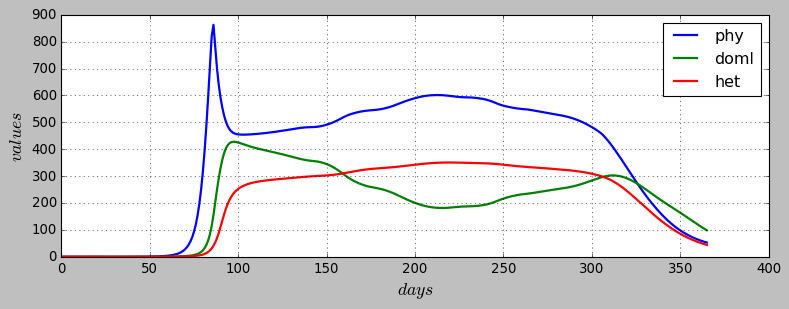

In [13]:
pf.plot_triple(phy,'phy',doml,'doml',het,'het')

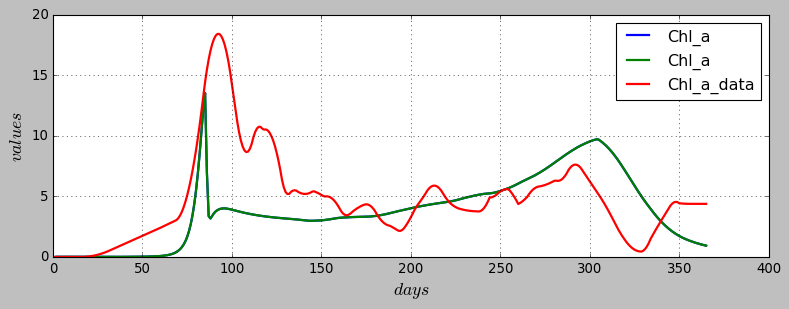

In [14]:
pf.plot_triple(chl_a,'Chl_a',chl_a,'Chl_a',chl_a_data,'Chl_a_data')